# Business Goal: To predict the bicycle demand at stations

### Import and clean data

“Given the forecasted weather conditions, how many bicycles can we expect to be rented out (city-wide) this Saturday at 2pm?”

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

# sklearn environment
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import dataframe_image as dfi

# Styling the plot
sns.set()
sns.set_style("darkgrid")
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10,5)  # --> set the default figure size

In [2]:
df_bike_train = pd.read_csv('data/biketrain.csv', parse_dates = ['datetime'])
df_bike_test = pd.read_csv('data/biketest.csv', parse_dates = ['datetime'])

In [3]:
df_bike_train['datetime']=pd.to_datetime(df_bike_train['datetime'])
df_bike_test['datetime']=pd.to_datetime(df_bike_test['datetime'])

In [4]:
#to pull out year, month, day, and hour from date time stamp
df_bike_train['year'] = df_bike_train['datetime'].dt.year
df_bike_train['month'] = df_bike_train['datetime'].dt.month
df_bike_train['day'] = df_bike_train['datetime'].dt.dayofweek
df_bike_train['hour'] = df_bike_train['datetime'].dt.hour
df_bike_train = df_bike_train.set_index('datetime')


df_bike_train.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1


In [5]:
df_bike_test['year'] = df_bike_test['datetime'].dt.year
df_bike_test['month'] = df_bike_test['datetime'].dt.month
df_bike_test['day'] = df_bike_test['datetime'].dt.dayofweek
df_bike_test['hour'] = df_bike_test['datetime'].dt.hour
df_bike_test = df_bike_test.set_index('datetime')
#df=df.drop(['casual',registered], axis = 1)
df_bike_test.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
datetime,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,3,0
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,1


In [6]:
#df_bike_train.info()

In [7]:
df_bike_train.groupby('holiday').count()

,season,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
holiday,,,,,,,,,,,,,,
0,10575,10575,10575,10575,10575,10575,10575,10575,10575,10575,10575,10575,10575,10575
1,311,311,311,311,311,311,311,311,311,311,311,311,311,311


In [8]:
df_bike_train[['atemp', 'temp','windspeed']] = df_bike_train[['atemp','temp','windspeed']].astype(int)
df_bike_test[['atemp', 'temp','windspeed']] = df_bike_test[['atemp','temp','windspeed']].astype(int)

In [9]:
#df_bike_train.info()


In [10]:
#df_bike_train.isna().sum()

In [11]:
#To change some columns to categories
df_bike_train['season']=df_bike_train['season'].astype('category')
df_bike_train['weather']=df_bike_train['weather'].astype('category')
df_bike_train['day']=df_bike_train['day'].astype('category')
df_bike_train['month']=df_bike_train['month'].astype('category')

In [12]:
df_bike_test['season']=df_bike_test['season'].astype('category')
df_bike_test['weather']=df_bike_test['weather'].astype('category')
df_bike_test['day']=df_bike_test['day'].astype('category')
df_bike_test['month']=df_bike_test['month'].astype('category')

In [13]:
df_bike_train.groupby('season').count()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
season,,,,,,,,,,,,,,
1,2686,2686,2686,2686,2686,2686,2686,2686,2686,2686,2686,2686,2686,2686
2,2733,2733,2733,2733,2733,2733,2733,2733,2733,2733,2733,2733,2733,2733
3,2733,2733,2733,2733,2733,2733,2733,2733,2733,2733,2733,2733,2733,2733
4,2734,2734,2734,2734,2734,2734,2734,2734,2734,2734,2734,2734,2734,2734


# EDA-Exploratory Data Analysis

In [14]:
df_bike_train.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,year,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,19.740492,23.185468,61.886460,12.425684,36.021955,155.552177,191.574132,2011.501929,11.541613
std,0.166599,0.466159,7.792108,8.500893,19.245033,8.045583,49.960477,151.039033,181.144454,0.500019,6.915838
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,0.000000
25%,0.000000,0.000000,13.000000,16.000000,47.000000,7.000000,4.000000,36.000000,42.000000,2011.000000,6.000000
50%,0.000000,1.000000,20.000000,24.000000,62.000000,12.000000,17.000000,118.000000,145.000000,2012.000000,12.000000
75%,0.000000,1.000000,26.000000,31.000000,77.000000,16.000000,49.000000,222.000000,284.000000,2012.000000,18.000000
max,1.000000,1.000000,41.000000,45.000000,100.000000,56.000000,367.000000,886.000000,977.000000,2012.000000,23.000000


In [15]:
#df_bike_train.groupby('count').agg(['sum', 'mean','count']).sort_values('sum',ascending = False)


In [16]:
round(df_bike_train.groupby('month')['count'].agg(['sum', 'mean','count']).sort_values('sum',ascending = False),2)


,sum,mean,count
month,,,
6,220733,242.03,912
7,214617,235.33,912
8,213516,234.12,912
9,212529,233.81,909
10,207434,227.70,911
5,200147,219.46,912
11,176440,193.68,911
4,167402,184.16,909
12,160160,175.61,912


In [17]:
round(df_bike_train.groupby('day')['count'].agg(['sum', 'mean','count']).sort_values('sum',ascending = False),2)


,sum,mean,count
day,,,
5,311518,196.67,1584
3,306401,197.30,1553
4,302504,197.84,1529
0,295296,190.39,1551
2,292226,188.41,1551
1,291985,189.72,1539
6,285546,180.84,1579


In [18]:
#round(df_bike_train.groupby('hour')['count'].agg(['sum', 'mean','count']).sort_values('sum',ascending = False),2)


In [19]:
#round(df_bike_train.groupby('atemp')['count'].agg(['sum', 'mean','count']).sort_values('sum',ascending = False),2)


In [20]:
round(df_bike_train.groupby('weather')['count'].agg(['sum', 'mean','count']).sort_values('sum',ascending = False),2)


,sum,mean,count
weather,,,
1,1476063,205.24,7192
2,507160,178.96,2834
3,102089,118.85,859
4,164,164.00,1


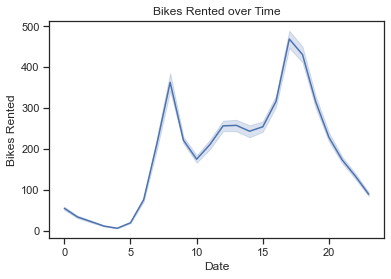

In [21]:
sns.lineplot(data=df_bike_train, x='hour', y='count', markers=True)
plt.ylabel('Bikes Rented')
plt.xlabel('Date')
plt.title('Bikes Rented over Time').get_figure().savefig('bike_rentals.png')
plt.show()

#shows a flux around school/work going to and from

In [22]:
#sns.heatmap(df_bike_train.isna(), cbar=False)

<AxesSubplot:>

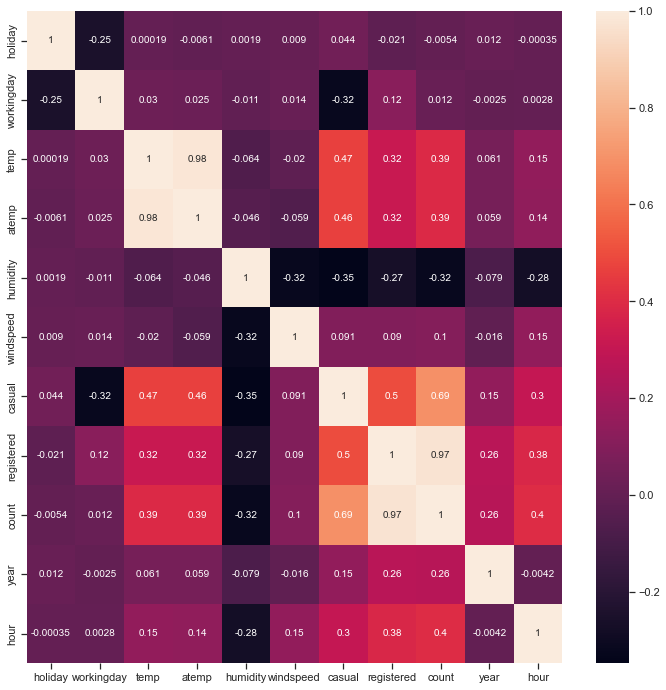

In [23]:
plt.figure(figsize=(12,12))
sns.heatmap(df_bike_train.corr(), annot = True) 


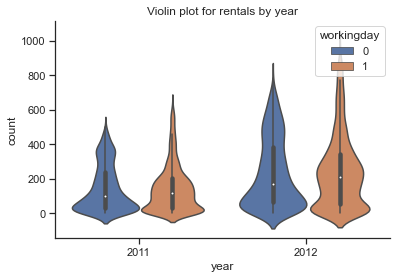

In [24]:
vio = sns.violinplot(data=df_bike_train, x= df_bike_train['year'], y='count', hue = 'workingday', alpha =0.4)
sns.despine()
vio.set_title('Violin plot for rentals by year')
sns.despine()

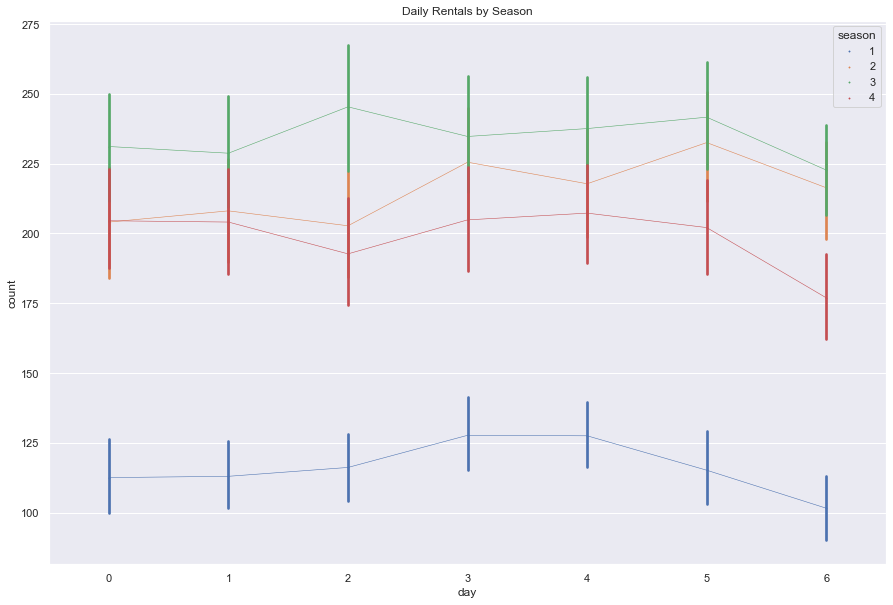

In [25]:
sns.set(rc={'figure.figsize':(15,10)})
sns.pointplot(data = df_bike_train[['day','count','season']], x = 'day', y = 'count',
              scale = 0.2, hue = 'season',fontsize = 16).set(title='Daily Rentals by Season');
#1 spring, 2 summer, 3 fall, 4 winter


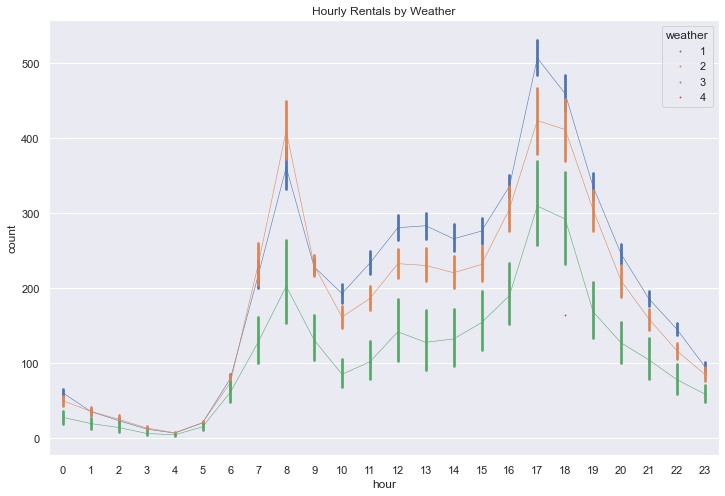

In [26]:
sns.set(rc={'figure.figsize':(12,8)})
sns.pointplot(data = df_bike_train[['hour','count','weather']], x = 'hour', y = 'count',
              scale = 0.2, hue = 'weather',fontsize = 18).set(title='Hourly Rentals by Weather');

#1 clear w/ few clouds, 2 misty/overcast, 3 light snow/rain, 4 heavy rain/snow/ice pellets


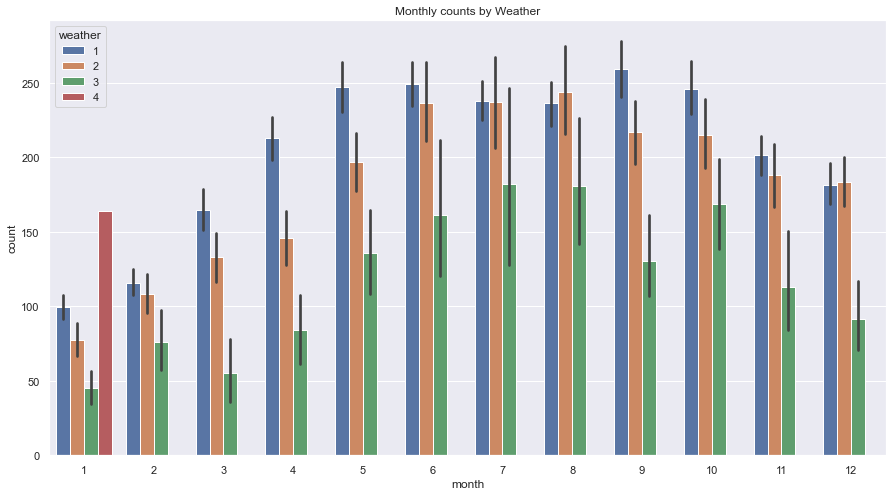

In [27]:
#Bar plot for weekday and monthly  counts
fig,ax1=plt.subplots(figsize=(15,8))
sns.barplot(x='month',y='count',data=df_bike_train[['month','count','weather']],hue='weather',ax=ax1)
ax1.set_title('Monthly counts by Weather')
plt.show()

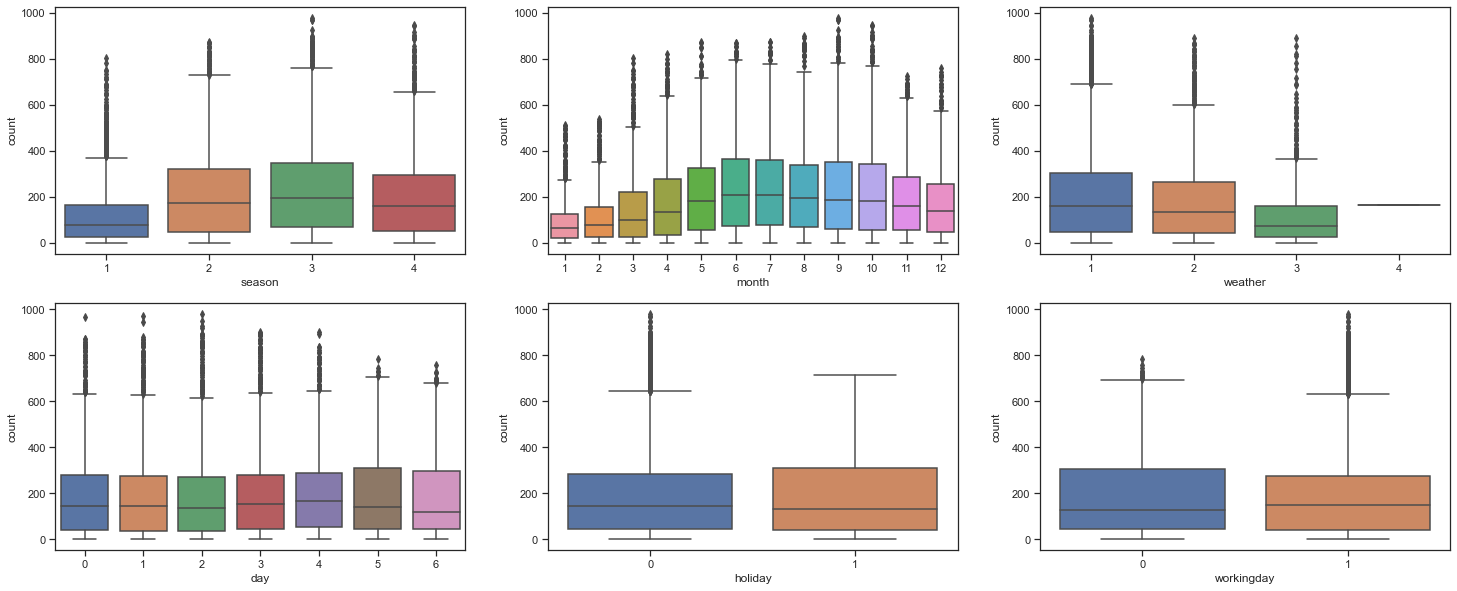

In [138]:
plt.figure(figsize=(25, 10))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'count', data = df_bike_train)
plt.subplot(2,3,2)
sns.boxplot(x = 'month', y = 'count', data = df_bike_train)
plt.subplot(2,3,3)
sns.boxplot(x = 'weather', y = 'count', data = df_bike_train)
plt.subplot(2,3,4)
sns.boxplot(x = 'day', y = 'count', data = df_bike_train)
plt.subplot(2,3,5)
sns.boxplot(x = 'holiday', y = 'count', data = df_bike_train)
plt.subplot(2,3,6)
sns.boxplot(x = 'workingday', y = 'count', data = df_bike_train).get_figure().savefig('bike_graphs6.png') 
plt.show()

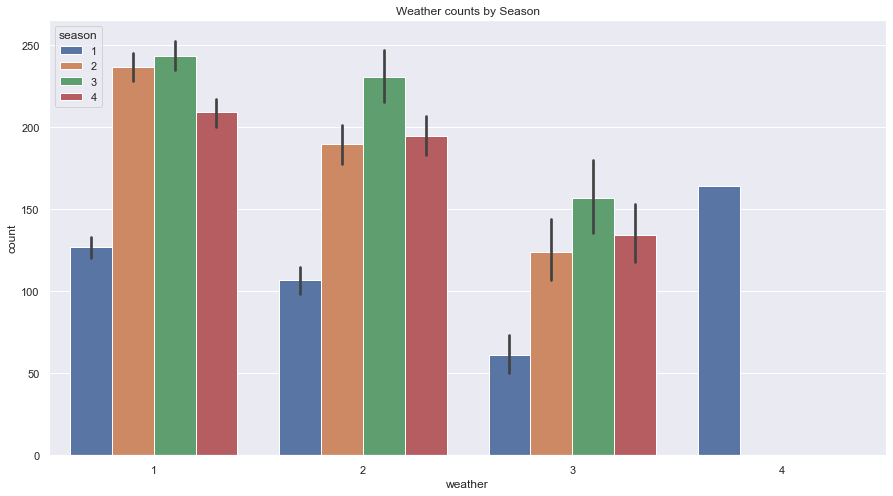

In [29]:
#Bar plot for weekday and monthly  counts
fig,ax1=plt.subplots(figsize=(15,8))
sns.barplot(x='weather',y='count',data=df_bike_train[['season','count','weather']],hue='season',ax=ax1)
ax1.set_title('Weather counts by Season')
plt.show()
#1 clear w/ few clouds, 2 misty/overcast, 3 light snow/rain, 4 heavy rain/snow/ice pellets


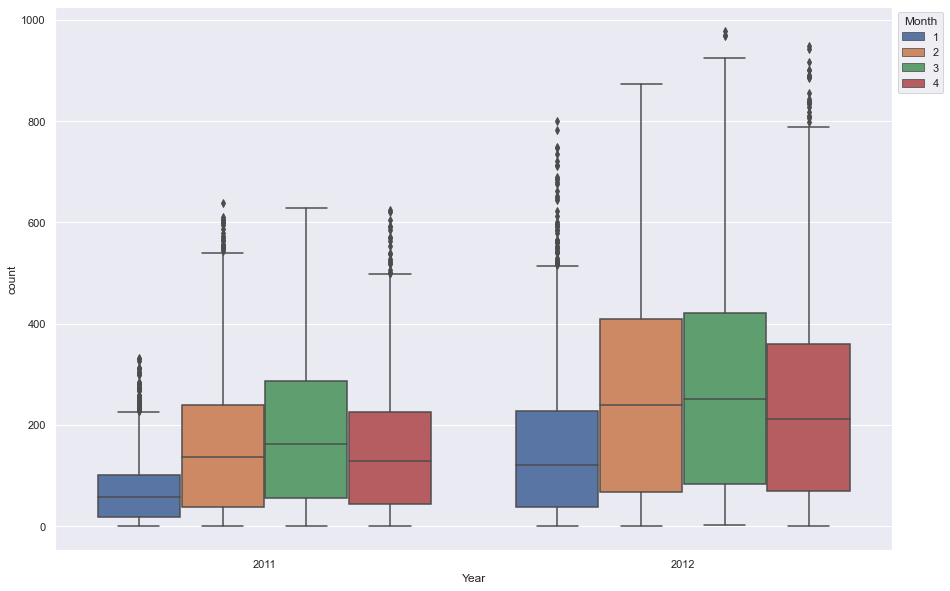

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(x=df_bike_train['year'], y=df_bike_train['count'], hue = df_bike_train['season'], ax=ax)
ax.legend(title='Month', bbox_to_anchor=(1, 1), loc='upper left')
ax.set(xlabel='Year')
plt.show()

In [31]:
df_bike_train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9,14,81,0,3,13,16,2011,1,5,0
2011-01-01 01:00:00,1,0,0,1,9,13,80,0,8,32,40,2011,1,5,1
2011-01-01 02:00:00,1,0,0,1,9,13,80,0,5,27,32,2011,1,5,2


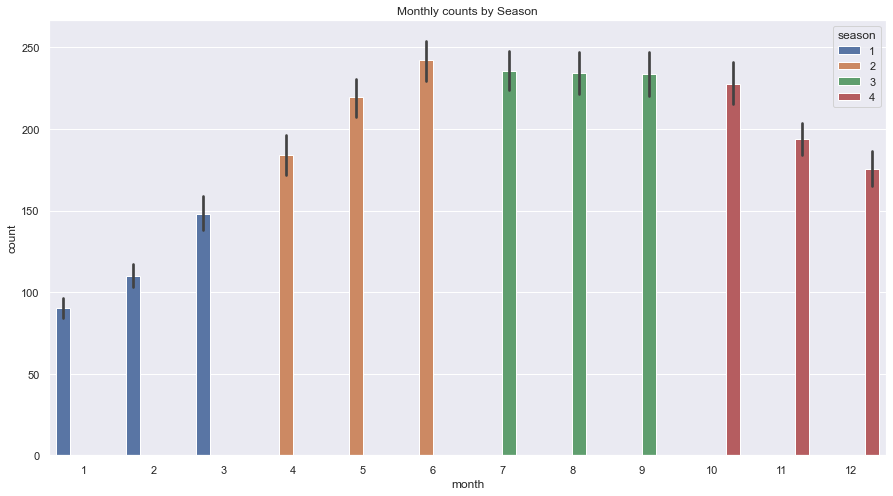

In [32]:
fig,ax=plt.subplots(figsize=(15,8))

#Bar plot for seasons and monthly counts
sns.barplot(x='month',y='count',data=df_bike_train[['month','count','season']],hue='season',ax=ax)
ax.set_title('Monthly counts by Season')
plt.show()

#1 = spring, 2 summer, 3 fall, 4 winter

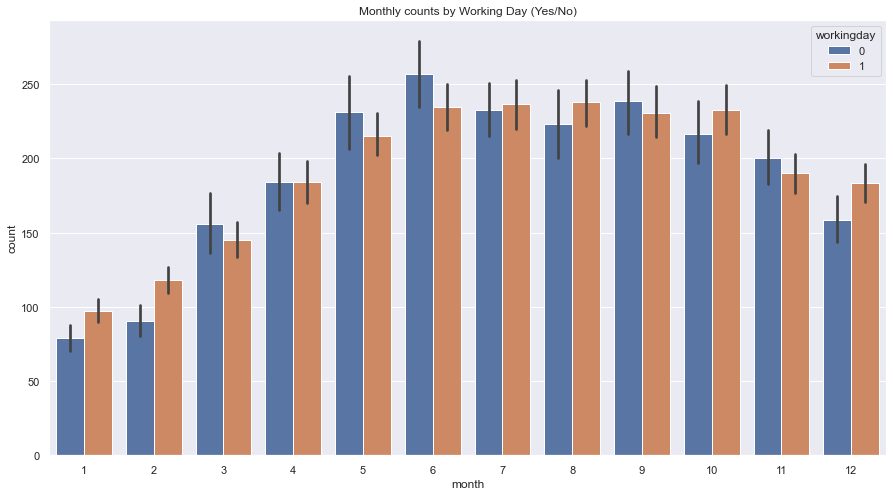

In [33]:
#Bar plot for weekday and monthly  counts
fig,ax1=plt.subplots(figsize=(15,8))
sns.barplot(x='month',y='count',data=df_bike_train[['month','count','workingday']],hue='workingday',ax=ax1)
ax1.set_title('Monthly counts by Working Day (Yes/No)')
plt.show()

To extract the time into seperate columns for analysis

In [34]:
df_bike_train.groupby('hour').agg({'count':'sum'})

,count
hour,
0,25088
1,15372
2,10259
3,5091
4,2832
5,8935
6,34698
7,96968
8,165060


In [35]:
df_bike_train.groupby('holiday').agg({'count':'sum'})

,count
holiday,
0,2027668
1,57808


<AxesSubplot:ylabel='count'>

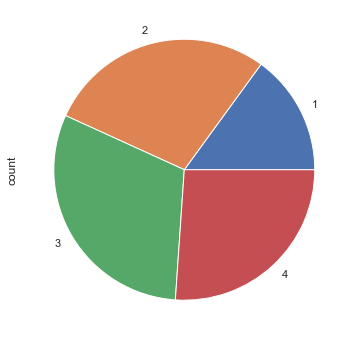

In [36]:
plt.figure(figsize=(6,6))
df_bike_train.groupby(["season"])["count"].sum().plot.pie()

In [37]:
df_bike_train.groupby('workingday').agg({'count':'sum'})

,count
workingday,
0,654872
1,1430604


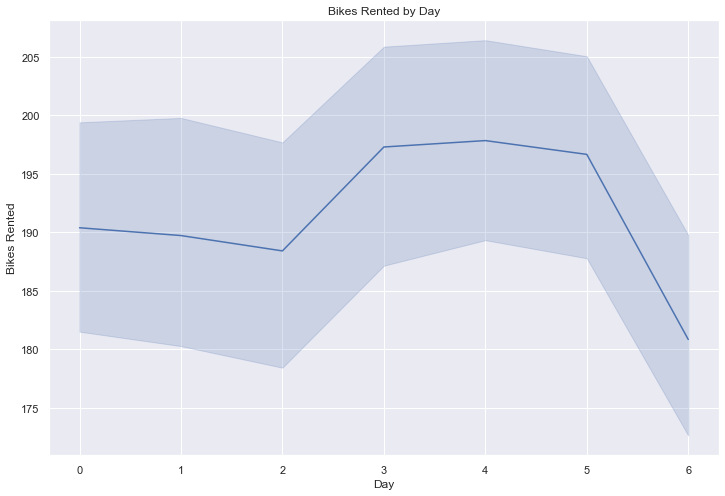

In [38]:
sns.lineplot(data=df_bike_train, x='day', y='count', markers=True)
plt.ylabel('Bikes Rented')
plt.xlabel('Day')
plt.title('Bikes Rented by Day')
plt.show()

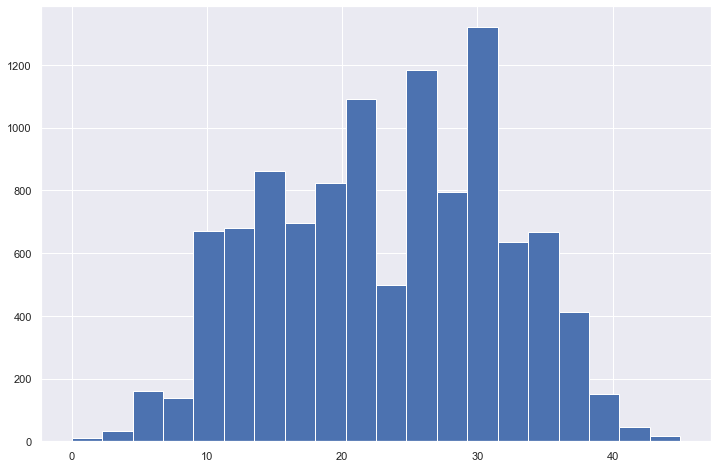

In [39]:
df_bike_train.atemp.hist(bins = 20);

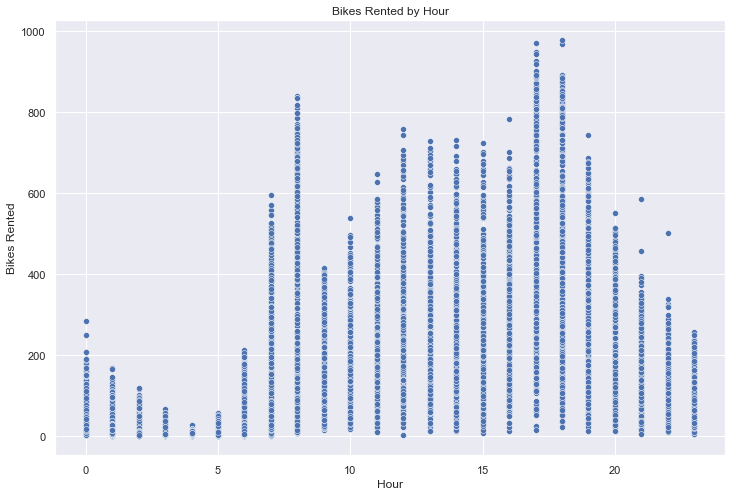

In [40]:
sns.scatterplot(data=df_bike_train, x='hour', y='count', markers=True)
plt.ylabel('Bikes Rented')
plt.xlabel('Hour')
plt.title('Bikes Rented by Hour')
plt.show()

In [41]:
df_bike_train.groupby(['day','hour']).agg({'count':'sum'})


count
day hour       
0   0      2307
    1      1175
    2       672
    3       335
    4       393
...         ...
6   19    14999
    20    11391
    21     8708
    22     6586
    23     4274

[168 rows x 1 columns]

In [42]:
df_bike_train.groupby(['day']).agg({'count':'mean'})

,count
day,
0,190.390716
1,189.723847
2,188.411348
3,197.296201
4,197.844343
5,196.665404
6,180.839772


##### Through the above analysis:

-most bicycles are rented on Wed/Thurs/Fri but daily mean of other days is not far behind (Sunday being lowest at 181 avg rentals)

-peak times are 8 am and 17h-18h 

-most bikes are rented with atemperatures (feels like temp) between 16-32

-less bikes rented in spring than any other season

-year over year increase in bike rentals

# Split Data (train and test, X,y)

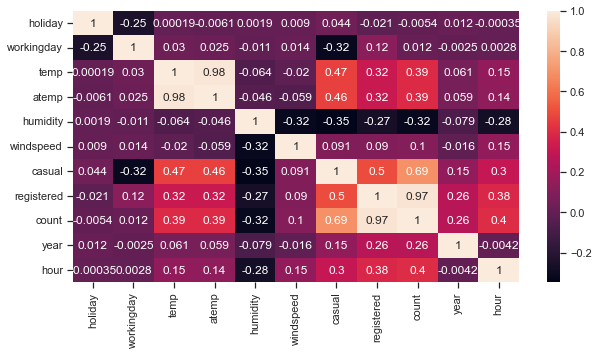

In [139]:
sns.heatmap(df_bike_train.corr(), annot=True).get_figure().savefig('bike_heatmap.png')

In [44]:
X=df_bike_train.drop(['casual', 'registered','season', 'atemp', 'count'], axis=1)
y=df_bike_train['count']
X2=df_bike_test.drop(['season', 'atemp'], axis=1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 12)

In [46]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8164, 10), (2722, 10), (8164,), (2722,))

In [47]:
X.columns

Index(['holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed',
       'year', 'month', 'day', 'hour'],
      dtype='object')

# Data Engineering

In [48]:
cat_pipe=make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [49]:
num_pipe = make_pipeline(
    RobustScaler(),
    StandardScaler(),
    MinMaxScaler()

)

In [50]:
X.columns, df_bike_test.columns

(Index(['holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed',
        'year', 'month', 'day', 'hour'],
       dtype='object'),
 Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
        'humidity', 'windspeed', 'year', 'month', 'day', 'hour'],
       dtype='object'))

In [51]:
feature_transform = ColumnTransformer([
    ('do_nothing', 'passthrough', ['holiday','workingday']),
    ('cat_processing', cat_pipe, ['weather','year','month','day','hour']),
    ('num_preprocessing', num_pipe, ['temp', 'humidity','windspeed'])
    ])

In [52]:
feature_transform.fit_transform(X_train)
feature_transform.fit_transform(X_test)
feature_transform.fit_transform(df_bike_test)

array([[0.        , 1.        , 1.        , ..., 0.25      , 0.47619048,
        0.47272727],
       [0.        , 1.        , 1.        , ..., 0.25      , 0.47619048,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.25      , 0.47619048,
        0.        ],
       ...,
       [0.        , 1.        , 1.        , ..., 0.25      , 0.52380952,
        0.2       ],
       [0.        , 1.        , 1.        , ..., 0.25      , 0.47619048,
        0.14545455],
       [0.        , 1.        , 1.        , ..., 0.25      , 0.58333333,
        0.14545455]])

# Random Forest Regressor Model

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8164, 10), (2722, 10), (8164,), (2722,))

In [54]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=4)    #Hyperparam: n_estimators(number of trees)
rfr.fit(X_train, (np.log1p(y_train)))

RandomForestRegressor(max_depth=4)

In [55]:
y_pred_rfr = np.expm1(rfr.predict(X_train))

In [56]:
y_pred_rfr.shape

(8164,)

In [57]:
round(rfr.score(X_train, y_train),3)

-1.056

In [58]:
round(rfr.score(X_test, y_test),3)

-1.057

In [59]:
importance = rfr.feature_importances_
importance

array([0.00000000e+00, 3.30828631e-02, 2.01812075e-04, 4.41194175e-02,
       8.47006320e-05, 0.00000000e+00, 3.37466004e-02, 2.61039237e-02,
       8.06469269e-03, 8.54595990e-01])

In [60]:
# summarize feature importance
for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,   v))

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.03308
Feature: 2, Score: 0.00020
Feature: 3, Score: 0.04412
Feature: 4, Score: 0.00008
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.03375
Feature: 7, Score: 0.02610
Feature: 8, Score: 0.00806
Feature: 9, Score: 0.85460


In [61]:
#fig = plt.figure(figsize=(9,5))

#plt.bar([x for x in range(len(importance))], importance)
#plt.title('Random Forest Feature Importance')
#plt.xticks(importance, ('Feature 0', 'Feature 1', 'Feature 2', 'Feature 3','Feature 4','Feature 5','Feature 6','Feature 7','Feature 8','Feature 9','Feature 10','Feature 11'))

In [62]:
RMSLE_RFR=np.sqrt(mean_squared_log_error(y_train, y_pred_rfr))
RMSLE_RFR

0.6465950916311589

### Cross Validation RFR

In [63]:
cross_r2_log_rfr = cross_val_score(rfr,  #estimator: the model that you want to evalueate
                                     X_train, # the training data
                                     y_train,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'r2' # evaluation metric

)



In [64]:
cross_r2_log_rfr

array([0.5912882 , 0.61713055, 0.60424354, 0.57493013, 0.59899076])

In [65]:
cross_r2_log_rfr.mean()

0.5973166376055519

# Train a linear regression model

### Linear Regression with Scikit Learn

In [66]:
mlr = LinearRegression()
mlr.fit(X_train, (np.log1p(y_train)))

LinearRegression()

In [67]:
round(mlr.score(X_train, y_train),3)

-1.059

In [68]:
y_pred_train_LR =np.expm1(mlr.predict(X_train))

### RMSLE_LR

In [69]:
#y_pred_test = mlr.predict(X_test)

In [70]:
RMSLE_LR=np.sqrt(mean_squared_log_error(y_train, y_pred_train_LR))
RMSLE_LR

1.0206598961863582

### Cross Validation on Linear Regression (X_train)

In [71]:
cross_R2_log_LR = cross_val_score(mlr,  #estimator: the model that you want to evalueate
                                     X_train, # the training data
                                     y_train,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'r2' # evaluation metric

)

In [72]:
cross_R2_log_LR

array([0.36413371, 0.38577081, 0.37775114, 0.3724656 , 0.4172155 ])

In [73]:
cross_R2_log_LR.mean()

0.3834673515876966

# Polynomial Regression

In [74]:
# Instantiate the transformationwith degree of 2
DEGREE = 2
poly = PolynomialFeatures(degree=DEGREE,include_bias=False)

In [75]:
# fit and transform on X_train
X_train_poly = poly.fit_transform(X_train)

In [76]:
# transform only on X_test
X_test_poly = poly.transform(X_test) 

In [77]:
#poly.get_feature_names()

In [78]:
# instantiate  Linear Regression
m_poly = LinearRegression()

# fit the model on X_train
m_poly.fit(X_train_poly, (np.log1p(y_train)))

LinearRegression()

In [79]:
# And the predictions
ypred_train_poly = np.expm1(m_poly.predict(X_train_poly))
ypred_test_poly = np.expm1(m_poly.predict(X_test_poly))

### RMSLE_poly

In [80]:
RMSLE_poly=np.sqrt(mean_squared_log_error(y_train, ypred_train_poly))
RMSLE_poly

0.8571817427654045

### Cross Validation Polynomial Regression

In [81]:
X_train_poly.shape, y_train.shape, X_test_poly.shape, y_test.shape

((8164, 65), (8164,), (2722, 65), (2722,))

In [82]:
cross_R2_log_poly = cross_val_score(m_poly,  #estimator: the model that you want to evalueate
                                     X_train_poly, # the training data
                                     y_train,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'r2' # evaluation metric

)


In [83]:
cross_R2_log_poly

array([0.52559571, 0.554765  , 0.5494229 , 0.52837266, 0.57972217])

In [84]:
cross_R2_log_poly.mean()

0.5475756891108887

# Regularization

In [85]:
m_elastic_net = ElasticNet(alpha=.1, l1_ratio=.5,
                           random_state=168)

In [86]:
m_elastic_net.fit(X_train_poly, (np.log1p(y_train))) 


ElasticNet(alpha=0.1, random_state=168)

In [87]:
X_train.shape

(8164, 10)

In [88]:
ypred_elastic = np.expm1(m_elastic_net.predict(X_train_poly))

In [89]:
ypred_elastic.shape

(8164,)

In [90]:
RMSLE_reg=np.sqrt(mean_squared_log_error(y_train, ypred_elastic))
RMSLE_reg

0.863915695740234

In [91]:
# r^2 and RMSE (root mean-squared error)
#m_poly_r2 = m_poly.score(X_train_poly, y)
#m_poly_rmse = np.sqrt(mean_squared_log_error(y_train, ypred_train_poly))

#m_elastic_r2 = m_elastic_net.score(X_poly,y)
#m_elastic_rmse = np.sqrt(mean_squared_log_error(y_train,ypred_elastic))

In [92]:
#plt.scatter(X_train,y_train,color='k',label='data')

#plt.plot(X_train_poly,ypred_train_poly, 
#        label = f'linear $R^2 = $ {m_poly_r2:.2f}, RMSE = {m_poly_rmse:.2f}')

#plt.plot(X_train,ypred_elastic,
#        label = f'elastic $R^2 = $ {m_elastic_r2:.2f}, RMSE = {m_elastic_rmse:.2f}')

#plt.xlabel('x')
#plt.ylabel('y')
#plt.ylim([-20,10])
#plt.legend(loc = 3);

# Hyperparameter Optimization with RFR

In [93]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, random_state = 12)

In [94]:
X_train1.shape, y_train1.shape

((8164, 10), (8164,))

In [95]:
 #initialise your model
RFR = RandomForestRegressor(n_estimators = 1, random_state = 0)
RFR.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [96]:
RFR.fit(X_train1, np.log1p(y_train1))

RandomForestRegressor(n_estimators=1, random_state=0)

In [97]:
training_score = RFR.score(X_train1, y_train1)
training_score

-1.0529345475614065

In [98]:
#Predictions on training data
y_pred_RFR = np.expm1(RFR.predict(X_train1))

In [99]:
y_pred_RFR.min()

0.9999999999999998

### GridSearchCV

In [104]:
parameters = { 'n_estimators' : [2 ** i for i in range(3, 10)],  # parameters grid
              'max_depth': [2, 4, 8, 16, 32, None]
}

In [105]:
cv_h = GridSearchCV(estimator=RFR, param_grid=parameters, cv=5, scoring='r2')

In [106]:
cv_h.fit(X_train1, (np.log1p(y_train1)))

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=1, random_state=0),
             param_grid={'max_depth': [2, 4, 8, 16, 32, None],
                         'n_estimators': [8, 16, 32, 64, 128, 256, 512]},
             scoring='r2')

In [107]:
def print_results(results):
    print('BEST MODEL PARAMETERS: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    for mean, params in zip(means, results.cv_results_['params']):
        print('{}  for {}'.format(round(mean, 4), params))

In [108]:
results = pd.DataFrame(cv_h.cv_results_)

In [109]:
#results.head(3)

In [110]:
#results[['mean_fit_time','rank_test_score',
#            'param_max_depth', 'param_n_estimators',
#             'split1_test_score', 'split2_test_score', 
#         'split3_test_score', 'split4_test_score','mean_test_score']].sort_values('mean_test_score')

In [111]:
RFR_best = cv_h.best_estimator_
RFR_best

RandomForestRegressor(n_estimators=512, random_state=0)

In [112]:
cross_r2 = cross_val_score(estimator=RFR_best,
                            X=X_train1,
                            y=y_train1,
                            cv=5,
                            scoring = 'r2'

)
cross_r2

array([0.93919836, 0.95192654, 0.93948867, 0.94832523, 0.94909619])

In [113]:
cross_r2.mean()

0.9456069963867624

In [114]:
#pred_test = RFC_best.predict(X_test)

In [115]:
pred_train = np.expm1(RFR_best.predict(X_train1))

In [116]:
#accuracy_score(y_test, pred), accuracy_score(y_train, pred_train)

### RMSLE_RFC

In [119]:
RMSLE_HORFR=np.sqrt(mean_squared_log_error(y_train1, pred_train))
RMSLE_HORFR

0.11185346172680659

# Final Model RFR (Kaggle Submission)

In [120]:
X_train.shape,y_train.shape, X_test.shape,y_test.shape

((8164, 10), (8164,), (2722, 10), (2722,))

In [121]:
X_train.columns

Index(['holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed',
       'year', 'month', 'day', 'hour'],
      dtype='object')

In [122]:
RFR = RandomForestRegressor(n_estimators = 128, max_depth = 8)

In [123]:
RFR.fit(X_train, (np.log1p(y_train)))

RandomForestRegressor(max_depth=8, n_estimators=128)

In [124]:
y_pred_RFR = np.expm1(RFR.predict(X_train))
y_pred_RFR_test = np.expm1(RFR.predict(X_test))

In [125]:
y_real_RFR = np.expm1(RFR.predict(X2))

In [126]:
y_real_RFR.shape

(6493,)

In [127]:
RMSLE_RFR=np.sqrt(mean_squared_log_error(y_train, y_pred_RFR))
RMSLE_RFR

0.34959499380971165

In [128]:
count = np.array(y_real_RFR)

In [129]:
df_bike_test['count']=count.tolist()

In [130]:
df_bike_test.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'count'],
      dtype='object')

In [131]:
lp=df_bike_test.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'hour'], axis = 1)

In [132]:
lp.reset_index()

,datetime,count
0,2011-01-20 00:00:00,11.412908
1,2011-01-20 01:00:00,4.920887
2,2011-01-20 02:00:00,3.104704
3,2011-01-20 03:00:00,2.236027
4,2011-01-20 04:00:00,2.180507
...,...,...
6488,2012-12-31 19:00:00,331.089586
6489,2012-12-31 20:00:00,260.212309
6490,2012-12-31 21:00:00,152.887846
6491,2012-12-31 22:00:00,119.873873


In [133]:
output = lp
output.to_csv('submission2.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# Conclusion

In [134]:
results = pd.DataFrame({
    'Model': ['Random Forest Regressor','Linear Regression', 'Polynomial', 'Poly Regression', 'Hyperparamenter Optimization with RFR'],
    
     'RMSLE': [RMSLE_RFR, RMSLE_LR, RMSLE_poly ,RMSLE_reg, RMSLE_HORFR]})
result_RMSLE = results.sort_values(by='RMSLE', ascending = True)
#result_RMSLE = result_RMSLE.set_index('Model')
result_RMSLE


,Model,RMSLE
4,Hyperparamenter Optimization with RFR,0.111853
0,Random Forest Regressor,0.349595
2,Polynomial,0.857182
3,Poly Regression,0.863916
1,Linear Regression,1.020660


In [137]:
dfi.export(result_RMSLE, 'bike_result_RMSLE.png')

objc[31644]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x22bb97808) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/102.0.5005.115/Libraries/libGLESv2.dylib (0x1086dd368). One of the two will be used. Which one is undefined.
[0623/134607.300372:INFO:headless_shell.cc(660)] Written to file /var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/tmpzx98eeqw/temp.png.
